In [0]:
# Education - Udacity "Intro to TensorFlow for Deep Learning"
# Module: Exercise - Flower Transfer Learning
# Ref: https://colab.research.google.com/github/tensorflow/examples/blob/master/courses/udacity_intro_to_tensorflow_for_deep_learning/l06c03_exercise_flowers_with_transfer_learning_solution.ipynb

In [1]:
# Import packages.
from __future__ import absolute_import, division, print_function, unicode_literals
import numpy as np
import matplotlib.pyplot as plt
import logging

# Using version 2.x of Tensorflow.
try:
  # Use the %tensorflow_version magic if in colab.
  %tensorflow_version 2.x
except Exception:
  pass

# Tensorflow.
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_datasets as tfds

# Set logging level.
logger = tf.get_logger()
logger.setLevel(logging.ERROR)

# Print Tensorflow version.
print('TensorFlow Version:', tf.__version__)

TensorFlow 2.x selected.
TensorFlow Version: 2.1.0-rc1


In [2]:
# Setup dataset.
# The model expects images of 224 x 224 with RGB.
print('Download and split the dataset....')
split = tfds.Split.TRAIN.subsplit(weighted = (70, 30))
(dataset_training, dataset_validation), dataset_info = tfds.load(
  'tf_flowers',
  with_info = True,
  as_supervised = True,
  split = split
)
print('Preparing completed.')

Download and split the dataset....


Dataset tf_flowers downloaded and prepared to /root/tensorflow_datasets/tf_flowers/1.0.0. Subsequent calls will reuse this data.
Preparing completed.


In [6]:
# Display info.
num_classes   = dataset_info.features['label'].num_classes
num_examples  = dataset_info.splits['train'].num_examples
calc_image_training    = num_examples * 0.7
calc_image_validation  = num_examples * 0.3

# Verify by iterating the dataset.
num_image_training = 0
for i in dataset_training:
  num_image_training += 1

num_image_validation = 0
for i in dataset_validation:
  num_image_validation += 1

print('-- Total Summary --')
print('Total Classes:    {}'.format(num_classes))
print('Total Exmples:    {}'.format(num_examples))
print('Total Training:   {}  True Size: ({})'.format(calc_image_training, num_image_training))
print('Total Validation: {}  True Size: ({})'.format(calc_image_validation, num_image_validation))
print('WARNING! We should iterate to count the number of data.')
print('Because the weighted split might be rounded up or down.')

-- Total Summary --
Total Classes:    5
Total Exmples:    3670
Total Training:   2569.0  True Size: (2590)
Total Validation: 1101.0  True Size: (1080)
WARNING! We should iterate to count the number of data.
Because the weighted split might be rounded up or down.


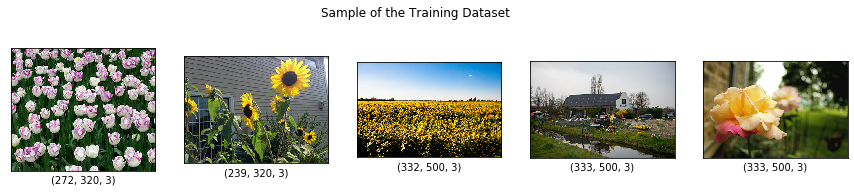

In [29]:
# Display some of the samples.
samples = dataset_training.take(5)
plt.figure(figsize = (15, 3))
for i, img in enumerate(samples):
  plt.subplot(1, 5, i + 1)
  plt.xticks([])
  plt.yticks([])
  plt.imshow(img[0])
  plt.xlabel(img[0].shape)
_ = plt.suptitle('Sample of the Training Dataset')

In [30]:
# Resize the images.
IMAGE_RES   = 224
BATCH_SIZE  = 32

print('Resize Process....')
print('Resize into {} x {}'.format(IMAGE_RES, IMAGE_RES))

def formatImage(image, label):
  image = tf.image.resize(image, (IMAGE_RES, IMAGE_RES)) / 255.0
  return image, label

batch_training    = dataset_training.shuffle(num_image_training//4).map(formatImage).batch(BATCH_SIZE).prefetch(1)
batch_validation  = dataset_validation.map(formatImage).batch(BATCH_SIZE).prefetch(1)
print('Resize Completed.') 

Resize Process....
Resize into 224 x 224
Resize Completed.


In [31]:
# Using the latest feature vector as base model.
print('Using ModelNet as base.')
URL = 'https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4'
feature_extractor = hub.KerasLayer(URL, input_shape=(IMAGE_RES, IMAGE_RES, 3))

# Freeze the extrator so we don't update its pretraing values.
feature_extractor.trainable = False
print('Freezing the extractor.')

Using ModelNet as base.
Freezing the extractor.


In [33]:
# Build our model to classify the flowers.
model = tf.keras.Sequential()
model.add(feature_extractor)
model.add(tf.keras.layers.Dense(num_classes, activation='softmax'))

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 1280)              2257984   
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 6405      
Total params: 2,264,389
Trainable params: 6,405
Non-trainable params: 2,257,984
_________________________________________________________________


In [35]:
# Train the model.
EPOCHS = 6
print('Total Epochs: {}'.format(EPOCHS))
print('Compile the model.')
model.compile(
  optimizer='adam',
  loss='sparse_categorical_crossentropy',
  metrics=['accuracy']
)

print('Start training the model.')
history = model.fit(
  batch_training,
  epochs=EPOCHS,
  validation_data = batch_validation
)
print('Training the model completed.')

Total Epochs: 6
Compile the model.
Start training the model.
Epoch 1/6
81/81 [==============================] - 15s 187ms/step - loss: 0.7453 - accuracy: 0.7301 - val_loss: 0.4950 - val_accuracy: 0.8102
Epoch 2/6
81/81 [==============================] - 7s 91ms/step - loss: 0.3679 - accuracy: 0.8726 - val_loss: 0.4013 - val_accuracy: 0.8556
Epoch 3/6
81/81 [==============================] - 8s 93ms/step - loss: 0.2846 - accuracy: 0.9054 - val_loss: 0.3922 - val_accuracy: 0.8639
Epoch 4/6
81/81 [==============================] - 8s 93ms/step - loss: 0.2365 - accuracy: 0.9251 - val_loss: 0.3707 - val_accuracy: 0.8722
Epoch 5/6
81/81 [==============================] - 7s 92ms/step - loss: 0.2015 - accuracy: 0.9425 - val_loss: 0.3478 - val_accuracy: 0.8787
Epoch 6/6
81/81 [==============================] - 7s 90ms/step - loss: 0.1764 - accuracy: 0.9517 - val_loss: 0.3432 - val_accuracy: 0.8833
Training the model completed.


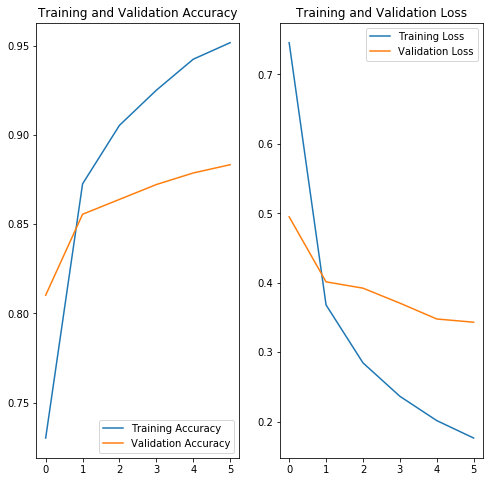

In [36]:
info_traing_accuracy      = history.history['accuracy']
info_validation_accuraty  = history.history['val_accuracy']
info_training_loss        = history.history['loss']
info_validation_loss      = history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, info_traing_accuracy, label = 'Training Accuracy')
plt.plot(epochs_range, info_validation_accuraty, label = 'Validation Accuracy')
plt.legend(loc = 'lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, info_training_loss, label = 'Training Loss')
plt.plot(epochs_range, info_validation_loss, label = 'Validation Loss')
plt.legend(loc = 'upper right')
plt.title('Training and Validation Loss')
plt.show()

In [41]:
# Predict testing.
class_names = np.array(dataset_info.features['label'].names)

batch_image, batch_label = next(iter(batch_training))
batch_image = batch_image.numpy()
batch_label = batch_label.numpy()

batch_predicted = model.predict(batch_image)
batch_predicted = tf.squeeze(batch_predicted).numpy()

predicted_ids     = np.argmax(batch_predicted, axis=-1)
predicted_classes = class_names[predicted_ids]

print('Class Names:       {}'.format(class_names))
print('Predicted IDs:     {}'.format(predicted_ids))
print('Predicted Classes: {}'.format(predicted_classes))
print('Labels:            {}'.format(batch_label))

Class Names:       ['dandelion' 'daisy' 'tulips' 'sunflowers' 'roses']
Predicted IDs:     [1 3 4 0 2 4 2 3 2 1 2 1 3 0 3 0 4 3 0 0 1 0 3 2 3 1 0 0 4 1 3 3]
Predicted Classes: ['daisy' 'sunflowers' 'roses' 'dandelion' 'tulips' 'roses' 'tulips'
 'sunflowers' 'tulips' 'daisy' 'tulips' 'daisy' 'sunflowers' 'dandelion'
 'sunflowers' 'dandelion' 'roses' 'sunflowers' 'dandelion' 'dandelion'
 'daisy' 'dandelion' 'sunflowers' 'tulips' 'sunflowers' 'daisy'
 'dandelion' 'dandelion' 'roses' 'daisy' 'sunflowers' 'sunflowers']
Labels:            [1 3 4 0 2 2 2 3 2 1 2 1 3 0 3 0 4 3 0 0 1 0 3 2 3 1 0 0 4 1 3 3]


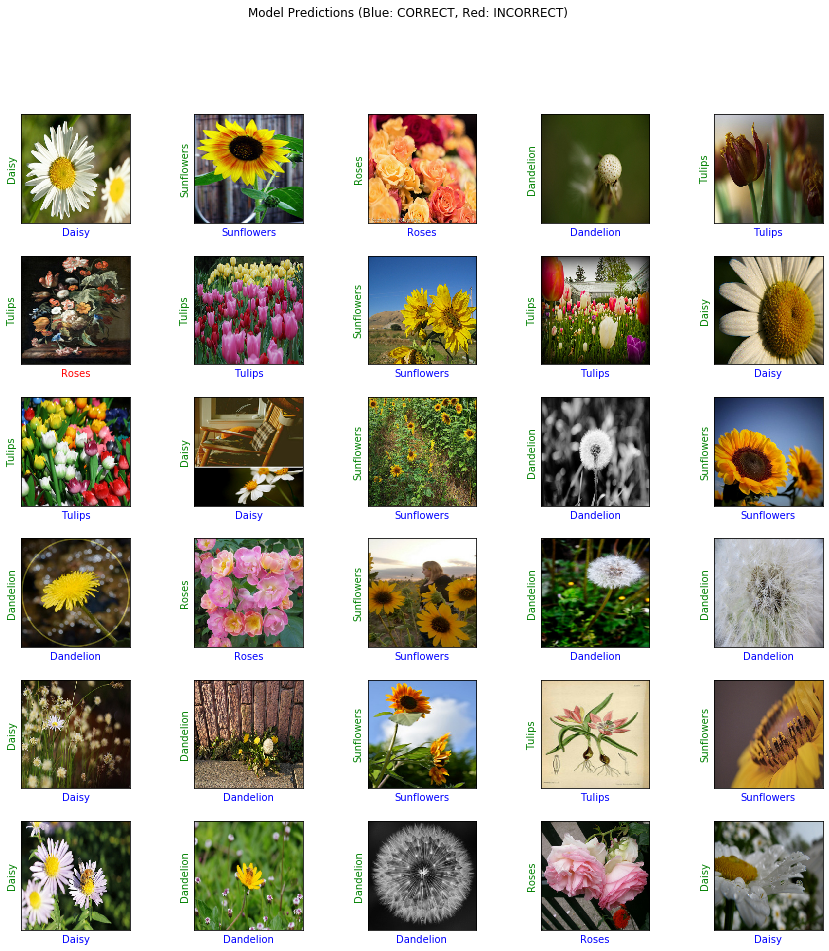

In [51]:
plt.figure(figsize=(15, 15))
for i in range(30):
  plt.subplot(6, 5, i + 1)
  plt.xticks([])
  plt.yticks([])
  plt.subplots_adjust(hspace = 0.3)
  plt.imshow(batch_image[i])
  color = "blue" if predicted_ids[i] == batch_label[i] else "red"
  plt.xlabel(predicted_classes[i].title(), color = color)
  plt.ylabel(class_names[batch_label[i]].title(), color = 'green')
_ = plt.suptitle("Model Predictions (Blue: CORRECT, Red: INCORRECT)")